# Import Libraries

In [123]:
import os
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set Parameters

In [124]:
dataset_nr = 2
assert dataset_nr == 1 or 2

embedding_method = 'e2v'
assert embedding_method == 'e2v' or 'm2v'

seeded_emb = False

if seeded_emb:
    fixed_emb = '_seeded'
else:
    fixed_emb = ''

# Load Predictions

In [125]:
curr_working_dir = os.getcwd()
curr_output_dir = os.path.join(curr_working_dir, 'output')
dataset_output_dir = os.path.join(curr_output_dir, f'g{dataset_nr}_{embedding_method}{fixed_emb}')

if not os.path.exists(dataset_output_dir):
    print('First, run the edge2vec embedding script. Then, run this script.')
else:
    print(f'Output folder for dataset {dataset_nr} exists and will be loaded: {dataset_output_dir}')
    
run_folders_list = []
for item in os.listdir(dataset_output_dir):
    curr_path = os.path.join(dataset_output_dir, item)
    if os.path.isdir(curr_path) and 'run' in item:
        run_folders_list.append(item)

print(f'A total of {len(run_folders_list)} runs will be included in the analysis.')

pred_folders_paths = []
for run_folder in run_folders_list:
    run_path = os.path.join(dataset_output_dir, run_folder)
    pred_run_path = os.path.join(run_path, 'pred')
    pred_folders_paths.append(pred_run_path)

Output folder for dataset 2 exists and will be loaded: c:\Users\rosa-\Google Drive\Msc_Bioinformatics\thesis\XAIFO-ThesisProject\output\g2_e2v
A total of 10 runs will be included in the analysis.


# Similarity between top scoring symptom-drug pairs

In [126]:
drug_symptom_pairs_per_run = []

for index, pred_path in enumerate(pred_folders_paths):
    with open(f'{pred_path}/candidates_per_symptom_{dataset_nr}_{embedding_method}.pkl', 'rb') as f:
        loaded_list = pickle.load(f)
        
        drug_symptom_pairs = []
        
        for _, row in loaded_list.iterrows():
            symptom_id = row['Symptom']
            candidates = row['Candidates']
            
            for candidate in candidates:
                drug_symptom_pairs.append(tuple([symptom_id, candidate]))
                
        total_drug_symptom_pairs = len(drug_symptom_pairs)
    
    drug_symptom_pairs_per_run.append(drug_symptom_pairs)

In [127]:
similarity_matrix = {}

for index1, pairs1 in enumerate(drug_symptom_pairs_per_run):
    
    similarities = {}
    
    for index2, pairs2 in enumerate(drug_symptom_pairs_per_run):
        overlap = set([tuple(sorted(ele)) for ele in pairs1]) & set([tuple(sorted(ele)) for ele in pairs2])
        ratio_overlap = len(overlap) / total_drug_symptom_pairs * 100
        
        similarities[f'run {index2+1}'] = ratio_overlap
        
    similarity_matrix[f'run {index1+1}'] = similarities
    
similarity_matrix_df = pd.DataFrame(similarity_matrix)
similarity_matrix_df

,run 1,run 2,run 3,run 4,run 5,run 6,run 7,run 8,run 9,run 10
run 1,100.000000,58.024691,53.086420,48.148148,45.679012,45.679012,59.259259,59.259259,44.444444,54.320988
run 2,58.024691,100.000000,45.679012,44.444444,53.086420,48.148148,48.148148,41.975309,43.209877,46.913580
run 3,53.086420,45.679012,100.000000,40.740741,34.567901,28.395062,33.333333,56.790123,44.444444,59.259259
run 4,48.148148,44.444444,40.740741,100.000000,34.567901,33.333333,48.148148,45.679012,40.740741,41.975309
run 5,45.679012,53.086420,34.567901,34.567901,100.000000,49.382716,49.382716,37.037037,43.209877,43.209877
run 6,45.679012,48.148148,28.395062,33.333333,49.382716,100.000000,39.506173,46.913580,25.925926,41.975309
run 7,59.259259,48.148148,33.333333,48.148148,49.382716,39.506173,100.000000,46.913580,37.037037,38.271605
run 8,59.259259,41.975309,56.790123,45.679012,37.037037,46.913580,46.913580,100.000000,37.037037,53.086420
run 9,44.444444,43.209877,44.444444,40.740741,43.209877,25.925926,37.037037,37.037037,100.000000,39.506173
run 10,54.320988,46.913580,59.259259,41.975309,43.209877,41.975309,38.271605,53.086420,39.506173,100.000000


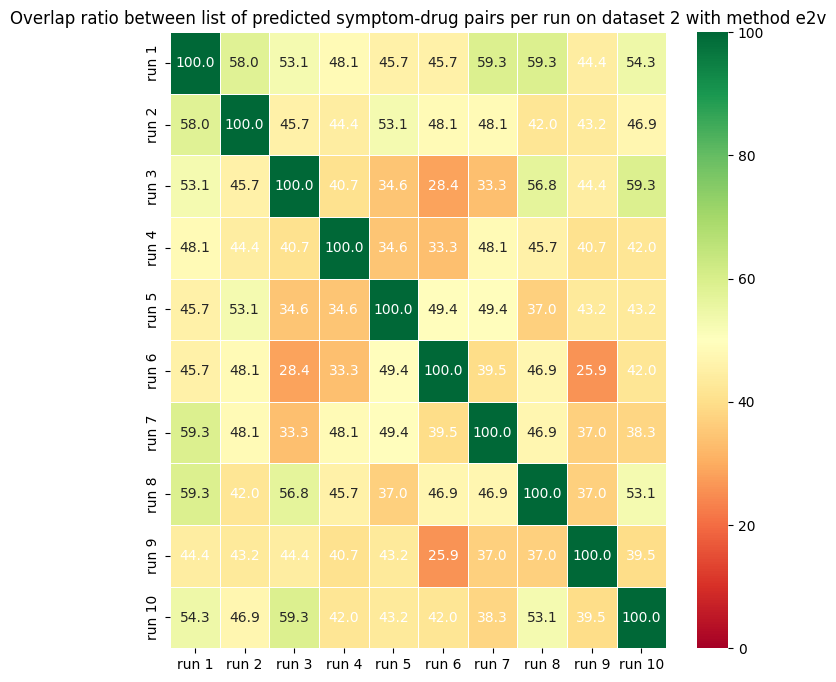

In [128]:
if seeded_emb:
    title_seeded = ' with fixed node embeddings'
else:
    title_seeded = ''

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title(f'Overlap ratio between list of predicted symptom-drug pairs per run on dataset {dataset_nr} with method {embedding_method}{title_seeded}')
sns.heatmap(similarity_matrix_df, annot=True, fmt='.1f', linewidths=0.5, ax=ax, cmap='RdYlGn')
ax.collections[0].set_clim(0,100)

fig.savefig(f'{dataset_output_dir}/overlap_between_runs.png', bbox_inches='tight')

In [129]:
for i in range(0, len(drug_symptom_pairs_per_run)):
    if i == 0:
        overlapping_pairs_all_runs = set(drug_symptom_pairs_per_run[i])
    else:
        overlapping_pairs_all_runs = overlapping_pairs_all_runs & set(drug_symptom_pairs_per_run[i])
            
print(f'There are {len(overlapping_pairs_all_runs)} symptom-drug pairs that are found in the top list of drug candidates in {len(drug_symptom_pairs_per_run)} runs: \n {overlapping_pairs_all_runs}')

with open(f'{dataset_output_dir}/symptom_drug_pair_overlapping_all_runs_{dataset_nr}_{embedding_method}{fixed_emb}.pkl', 'wb') as f:
    pickle.dump(overlapping_pairs_all_runs, f)

There are 8 symptom-drug pairs that are found in the top list of drug candidates in 10 runs: 
 {('HP:0001635', '1576'), ('HP:0001290', '269'), ('HP:0008981', '1576'), ('HP:0011675', '1576'), ('HP:0001644', '1576'), ('HP:0011675', '231'), ('HP:0003701', '1576'), ('HP:0003236', '1576')}
